## Linguagem natural

No Kraggle pegamos um df com resenhas do imdb em pt-br, com ela já analisada o sentimento como negativo ou positivo

In [1]:
import pandas as pd

resenha = pd.read_csv("dados/imdb-reviews-pt-br.csv")

resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


Treinando com SKlearn  
<code>treino_x, teste_x, treino_y, teste_y = train_test_split(TREINAMENTO_X, TREINAMENTO_Y, random_state = SEMENTE, test_size = PORCENTAGEM_DE_ELEMENTOS_QUE_SERVIRÁ_PARA_TESTE)</code>

In [2]:
from sklearn.model_selection import train_test_split

treino, teste, classe_treino, classe_teste = train_test_split (resenha.text_pt,
                                                               resenha.sentiment,
                                                               random_state = 42)

Criaremos um modelo de treino, mas não podemos treinar strings, apenas numeros, então o NLP irá funcionar como um **tradutor** para que esse treinamento seja possível

In [3]:
from sklearn.linear_model import LogisticRegression

#regressao_logistica = LogisticRegression()
#regressao_logistica.fit(treino, classe_treino)
#acuracia = regressao_logistica.score(teste, classe_teste)
#acuracia

Verificando quantidades: `.value_counts()`  
Organizando o DF


In [4]:
print(resenha.sentiment.value_counts())

classificacao = resenha["sentiment"].replace(["neg", "pos"], [0,1])

resenha["classificacao"] = classificacao
resenha.head()

neg    24765
pos    24694
Name: sentiment, dtype: int64


,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


### Definindo o tone analyse

Para se iniciar uma classificação de linguagem natural, utilizamos o chamado **Bag of Words** que é criar vetores de frase e atribuir valores as palavras que estão presentes neles, 0->não e 1->sim  
Para termos noção do nosso dicionário usamos `.get_feature_names()`  
`lowercase=False` "impede" o case sentive, pois é tudo transformado em letra minúscula por default

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

texto = ["Assisti um filme ótimo", "Assisti um filme ruim"]

vetorizar = CountVectorizer(lowercase=False)
bag_of_words = vetorizar.fit_transform(texto)

vetorizar.get_feature_names()

['Assisti', 'filme', 'ruim', 'um', 'ótimo']

Matri esparça são matriz que tem muitos valores zero e para poupar memória podemos setar como **NaN**. Podemos converte-la pra normal com `.SparceDataFrame`, assim podendo trabalhar com ela

In [6]:
matriz_esparsa = pd.SparseDataFrame(bag_of_words,
                                    columns=vetorizar.get_feature_names())
matriz_esparsa

,Assisti,filme,ruim,um,ótimo
0,1,1,NaN,1,1.0
1,1,1,1.0,1,NaN


In [7]:
vetorizar = CountVectorizer(lowercase=False)
bag_of_words = vetorizar.fit_transform(resenha.text_pt)
bag_of_words.shape

(49459, 156923)

O processamento é proporcional ao vetor, então, podemos limita-lo para uma melhor análise utilizando `max_features` que delimita a quantidade que queremos, colocando as palavras que mais aparecem como prioridade

In [8]:
vetorizar = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vetorizar.fit_transform(resenha.text_pt)
bag_of_words.shape

(49459, 50)

In [9]:
treino, teste, classe_treino, classe_teste = train_test_split (bag_of_words,
                                                               resenha.sentiment,
                                                               random_state = 42)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia = regressao_logistica.score(teste, classe_teste)
acuracia

c:\users\lucas.azevedo\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6583097452486858

In [10]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split (bag_of_words,
                                                                   texto[coluna_classificacao],
                                                                   random_state = 42)
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)

#Teste
print(classificar_texto(resenha, "text_pt", "classificacao"))

    

c:\users\lucas.azevedo\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6583097452486858


## Criando uma word cloud

In [11]:
#para que a plotagem seja no notebook
%matplotlib inline 

import matplotlib.pyplot as plt

from wordcloud import WordCloud

Faremos uma lista comprehension no python,  para termos todas as palavras do documento numa lista com todos os elementos

In [12]:
todas_palavras = ' '.join([texto for texto in resenha.text_pt])
len(todas_palavras)

63448424

Recebemos uma imagem como retorno, então temos que plota-la  
`collocations = False` remove os bigramas

In [13]:
nuvem_palavras = WordCloud(width=800, height=500,
                           max_font_size = 110,
                           collocations = False).generate(todas_palavras)

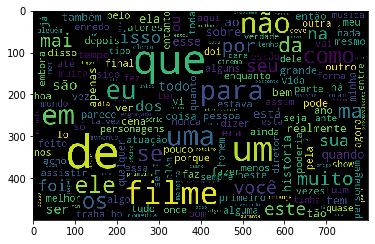

In [14]:
plt.figure()
plt.imshow(nuvem_palavras)
plt.show()

Ajustando

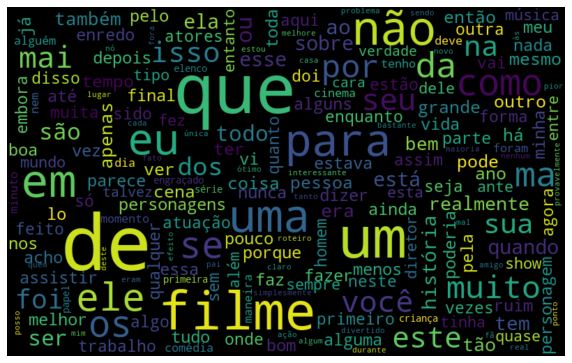

In [15]:
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

### Dividindo entre positivos e negativos

Para dividir precismos dividir os dados do datafrmae e para isso utilizaremos as bibliotecas do pandas, dividindo utilizando querys `.query` realiza uma consulta no banco de dados

In [16]:
resenha.query("sentiment ==  'pos'").head()

,id,text_en,text_pt,sentiment,classificacao
12389,12391,I went and saw this movie last night after bei...,Eu fui e vi este filme ontem à noite depois de...,pos,1
12390,12392,Actor turned director Bill Paxton follows up h...,"O diretor do ator, Bill Paxton, segue sua prom...",pos,1
12391,12393,As a recreational golfer with some knowledge o...,Como um jogador de recreio com algum conhecime...,pos,1
12392,12394,"I saw this film in a sneak preview, and it is ...","Eu vi esse filme em uma prévia, e é delicioso....",pos,1
12393,12395,Bill Paxton has taken the true story of the 19...,Bill Paxton levou a verdadeira história do gol...,pos,1


In [17]:
def nuvem_palavras(texto, coluna_texto, tipo):
    if tipo == 'neg':
        tipo = texto.query("sentiment == 'neg'")
        
    elif tipo == 'pos':
        tipo = texto.query("sentiment == 'pos'")
        
    todas_palavras = ' '.join([texto for texto in tipo[coluna_texto]])

    nuvem_palavras = WordCloud(width=800, height=500,
                               max_font_size = 110,
                               collocations = False).generate(todas_palavras)

    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

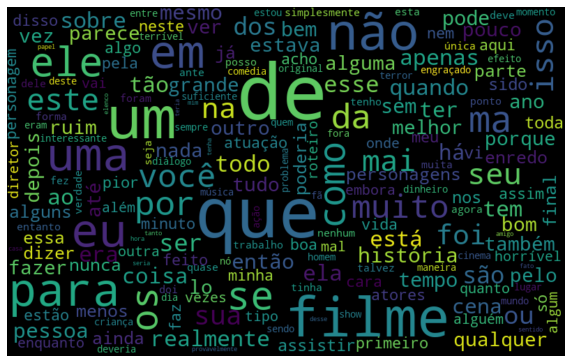

In [18]:
nuvem_palavras(resenha, "text_pt", "neg")

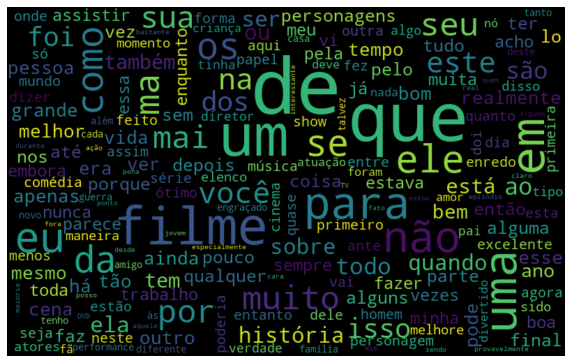

In [19]:
nuvem_palavras(resenha, "text_pt", "pos")

NLTK é uma biblioteca que podemos tratar textos, nesse caso a quantidade que ele aparece e etc. Separando as palavras por token

In [26]:
import nltk
from nltk import tokenize

token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)

frequencia

FreqDist({'de': 417651, 'que': 325070, 'e': 299743, 'o': 244881, 'um': 216410, 'a': 210179, 'é': 192381, 'em': 132778, 'uma': 130888, 'não': 127915, ...})

Criando um df, para melhor manipulação `.nlargest` Ordena os dados do Dataframe

In [27]:
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                              "Frequencia": list(frequencia.values())})

df_frequencia.nlargest(columns = "Frequencia", n = 10)

,Palavra,Frequencia
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


Plotando o gráfico

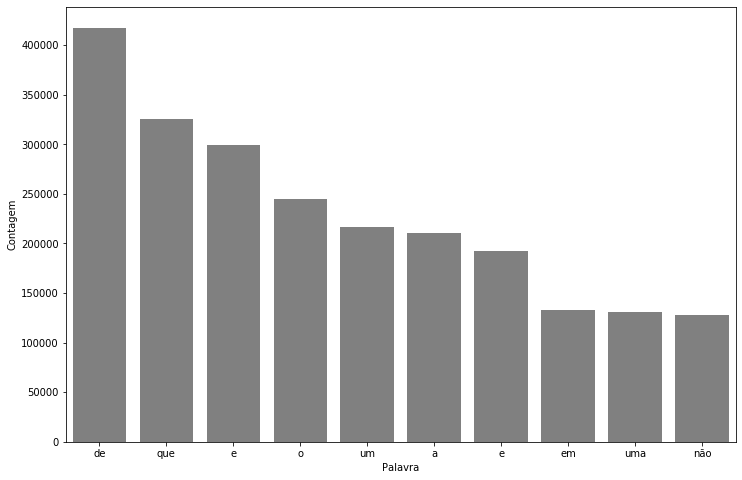

In [31]:
import seaborn as sns

def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist (token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                  "Frequencia": list(frequencia.values())})
    
    df_frequencia = df_frequencia.nlargest(columns = "Frequencia", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequencia", color = "gray")
    ax.set(ylabel = "Contagem")
    plt.show()  
    
pareto(resenha, "text_pt", 10)

Dentro dos idiomas existem palavras que são definidas como stop words, elas são irrelevantes para plotagem do gráfico por exemplo. Então é necessário remove-las para uma melhor análise

In [35]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

palavra_processada = []

for opiniao in resenha.text_pt:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    palavra_processada.append(' '.join(nova_frase))
            
resenha["tratamento_1"] = palavra_processada

resenha.head()


,id,text_en,text_pt,sentiment,classificacao,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este é exemplo motivo maioria filmes ação mesm...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão é palavra apropriada eles, ..."


Verificando se houve uma melhora após o tratamento

In [37]:
classificar_texto(resenha, "tratamento_1", "classificacao")

c:\users\lucas.azevedo\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6607359482410028

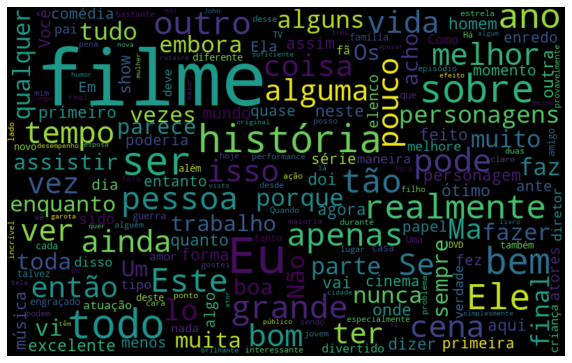

In [38]:
nuvem_palavras(resenha, "tratamento_1", "pos")

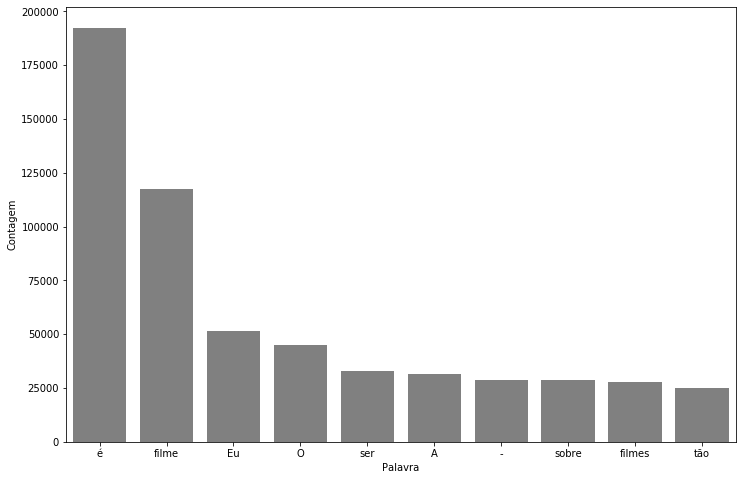

In [39]:
pareto(resenha, "tratamento_1", 10)